# Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.io import loadmat
from scipy import signal
from scipy.signal import butter, filtfilt, welch
import warnings
warnings.filterwarnings('ignore')
import os
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
!pip install mne
from mne.decoding import CSP
import mne
from google.colab import drive
drive.mount('/content/drive')
data='drive/My Drive/Motor Imagery/data_set_IVa_aw.mat'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 20.8 MB/s eta 0:00:00
Mounted at /content/drive


# Dataset Exploration

In [ ]:
data=loadmat(data)

In [ ]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'nfo', 'cnt'])

In [ ]:
data['cnt'][0:3,0:10]

array([[ 294,  -15,    9,  184,  611, -157, -156,  104,  517,  262],
       [ 386,  127,  110,  355,  802,  -88,  -39,  399,  722,  342],
       [ 325,   74,   83,  309,  757, -202,  -80,  362,  830,  292]],
      dtype=int16)

In [ ]:
data['cnt'].shape

(282838, 118)

In [ ]:
data['mrk']

array([[(array([[  5126,   5708,   6266,   7396,   7937,   8501,   9045,   9598,
                 10148,  12970,  13553,  14090,  14625,  15196,  15769,  17436,
                 18552,  21198,  21769,  22866,  23997,  25103,  25671,  26217,
                 26787,  27892,  28448,  30102,  30683,  31248,  31785,  32922,
                 33495,  34070,  37297,  37853,  38417,  38955,  40061,  40607,
                 41157,  42287,  42847,  43427,  44545,  46216,  47340,  48455,
                 48996,  50678,  53344,  53885,  54972,  56630,  57769,  58321,
                 58880,  60036,  60591,  61173,  62279,  62838,  63949,  64508,
                 65083,  65626,  66179,  67266,  67841,  69524,  76111,  76649,
                 77232,  78366,  78945,  79480,  80030,  80613,  81716,  82275,
                 82845,  83968,  84523,  85103,  85639,  86209,  87881,  88440,
                 89008,  92251,  92810,  93910,  94466,  97259,  97827,  98983,
                 99518, 100067, 100629,

# Data Preprocessing

In [ ]:
cnt=0.1*data['cnt'].astype(np.float32)

In [ ]:
cnt[0]

array([  29.4       ,   -1.5       ,    0.90000004,   18.4       ,
         61.100002  ,  -15.7       ,  -15.6       ,   10.400001  ,
         51.7       ,   26.2       ,   31.6       ,    9.1       ,
         52.9       ,  -74.700005  ,   -8.900001  ,    1.4       ,
         13.5       ,  -30.800001  ,   29.1       ,   24.4       ,
         30.4       ,   68.8       ,   15.6       ,    3.3       ,
         -1.8000001 ,   22.9       ,  -33.7       ,  -10.2       ,
        -14.6       ,   18.5       ,  -11.8       ,   49.        ,
         75.6       ,   61.600002  ,   -2.        ,  -14.7       ,
         30.6       ,    4.3       ,    7.4       ,   54.4       ,
         25.2       ,   42.4       ,  -43.7       , -145.2       ,
        -59.600002  ,   18.5       ,   46.3       ,   21.6       ,
        -49.7       ,   11.3       ,   37.4       ,  -14.        ,
         -4.        ,  -23.2       ,   11.        ,   -4.4       ,
         41.2       ,    8.8       ,   -7.8       ,   40.7    

In [ ]:
fs = data['nfo']['fs'][0][0][0][0]

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass(data, lowcut=8, highcut=30, fs=100):
    b, a = butter_bandpass(lowcut, highcut, fs)
    return filtfilt(b, a, data, axis=0)

filtered_cnt = apply_bandpass(cnt, lowcut=8, highcut=30, fs=fs)

In [ ]:
filtered_cnt[0]

array([ 1.73984007e-02,  2.09277806e-02,  1.89338276e-02,  3.37830502e-02,
        4.83495845e-02,  1.52676960e-02,  2.57785331e-02,  5.13609286e-02,
        1.19046778e-01,  2.72849212e-02,  3.12740840e-02,  4.18076394e-02,
        1.01634346e-01,  4.15689150e-02,  2.07194808e-02,  2.18988704e-02,
        2.65548932e-02,  3.36445402e-02,  5.18554616e-02,  6.05285623e-02,
        1.06985830e-01,  1.28818724e-01,  3.40264932e-02,  1.81315805e-02,
        2.38476766e-02,  3.26338520e-02,  4.19546053e-02,  3.73330453e-02,
        2.71087902e-02,  1.21459520e-01, -6.88798118e-02, -1.66589318e-02,
        1.71118150e-02,  1.94704859e-02,  2.10534799e-02,  2.80186632e-02,
        3.03731520e-02, -5.75827194e-03,  3.84746503e-02,  4.42791484e-02,
       -7.36846466e-02, -9.13210660e-02,  4.41061139e-02,  1.60137799e-02,
        1.97646326e-02,  2.18720058e-02, -4.10105094e-04,  1.08825621e-02,
        1.53980317e-01,  4.04993260e-02, -9.25739923e-02,  7.69380346e-03,
        5.91379586e-03,  

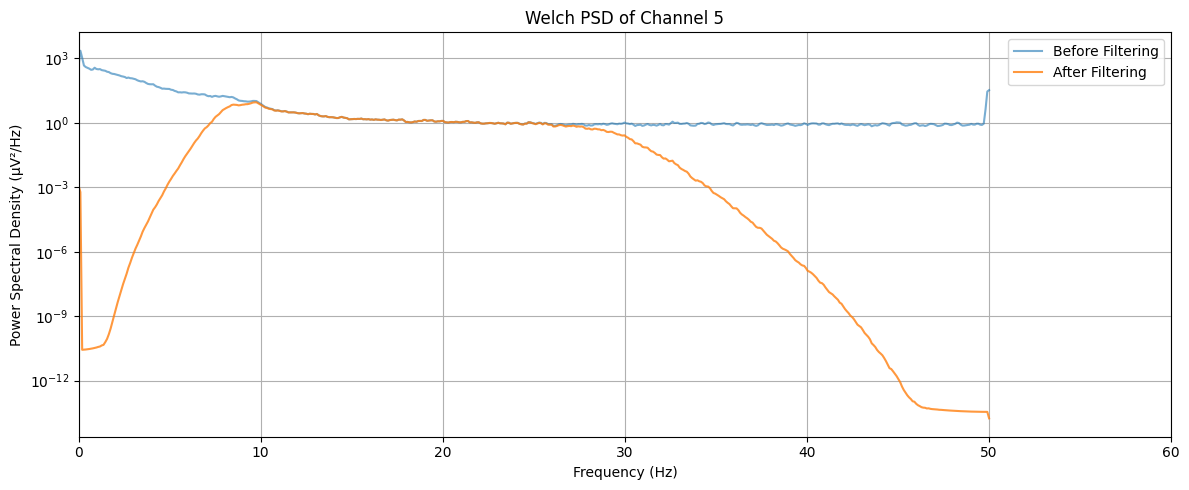

In [ ]:
channel_index = 5
raw_signal = cnt[:, channel_index]
filtered_signal = filtered_cnt[:, channel_index]

f_raw, psd_raw = welch(raw_signal, fs=fs, nperseg=1024)
f_filt, psd_filt = welch(filtered_signal, fs=fs, nperseg=1024)

plt.figure(figsize=(12, 5))
plt.semilogy(f_raw, psd_raw, label='Before Filtering', alpha=0.6)
plt.semilogy(f_filt, psd_filt, label='After Filtering', alpha=0.8)
plt.xlim(0, 60)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (µV²/Hz)")
plt.title(f"Welch PSD of Channel {channel_index}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


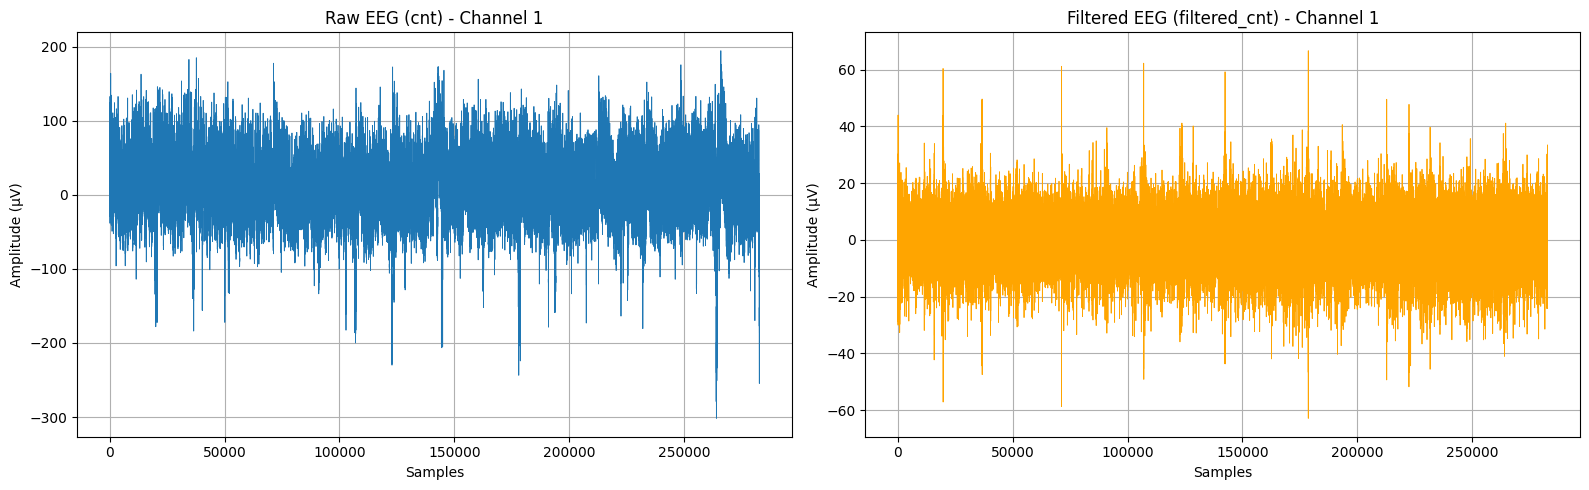

In [ ]:
channel = 1

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(cnt[:, channel], linewidth=0.6)
plt.title(f"Raw EEG (cnt) - Channel {channel}")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(filtered_cnt[:, channel], linewidth=0.6, color='orange')
plt.title(f"Filtered EEG (filtered_cnt) - Channel {channel}")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
mrk = {
    'pos': data['mrk']['pos'][0][0].flatten(),
    'y': data['mrk']['y'][0][0].flatten()
}

In [ ]:
mrk_y=mrk['y']
mrk_pos=mrk['pos']

In [ ]:
y = mrk_y.flatten()

labeled_idx = np.where(~np.isnan(y))[0]

unlabeled_idx = np.where(np.isnan(y))[0]

print("Labeled trials:", len(labeled_idx))
print("Unlabeled trials:", len(unlabeled_idx))

pos_labeled = mrk_pos[labeled_idx]
pos_unlabeled = mrk_pos[unlabeled_idx]

y_labeled = y[labeled_idx].astype(int)


Labeled trials: 56
Unlabeled trials: 224


In [ ]:
def create_epochs(cnt, positions, fs, tmin=0.5, tmax=3.1):
    samples_before = int(tmin * fs)
    samples_after  = int(tmax * fs)
    window_size    = samples_after - samples_before

    epochs = []
    for p in positions:
        start = p + samples_before
        stop  = p + samples_after
        epochs.append(cnt[start:stop])
    return np.array(epochs)


X_labeled = create_epochs(filtered_cnt, pos_labeled, fs)
X_unlabeled = create_epochs(filtered_cnt, pos_unlabeled, fs)

print(X_labeled.shape, y_labeled.shape)
print(X_unlabeled.shape)


(56, 260, 118) (56,)
(224, 260, 118)


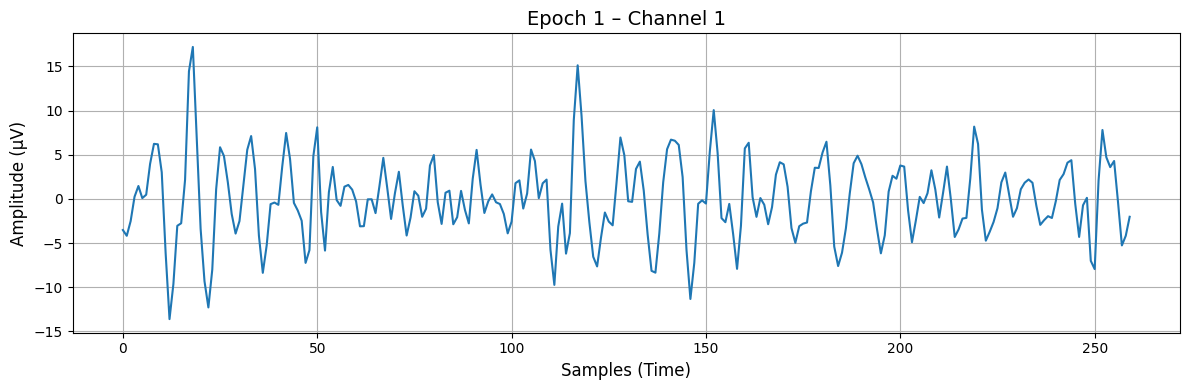

In [ ]:
epoch_idx = 0
channel_idx = 0

epoch = X_labeled[epoch_idx]

plt.figure(figsize=(12, 4))
plt.plot(epoch[:, channel_idx])

plt.title(f"Epoch {epoch_idx+1} – Channel {channel_idx+1}", fontsize=14)
plt.xlabel("Samples (Time)", fontsize=12)
plt.ylabel("Amplitude (µV)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
clab_raw = data['nfo']['clab'][0][0]
if clab_raw.shape[0] == 1:
    clab_raw = clab_raw[0]
clab = [str(ch[0]) for ch in clab_raw]

PSD ANALYSIS - RIGHT HAND VS FOOT
Selected channel: Fp1 (index: 0)

Data shape: (56, 260, 118)
Right hand epochs: (30, 260, 118)
Foot epochs: (26, 260, 118)

Computing PSD for channel Fp1...


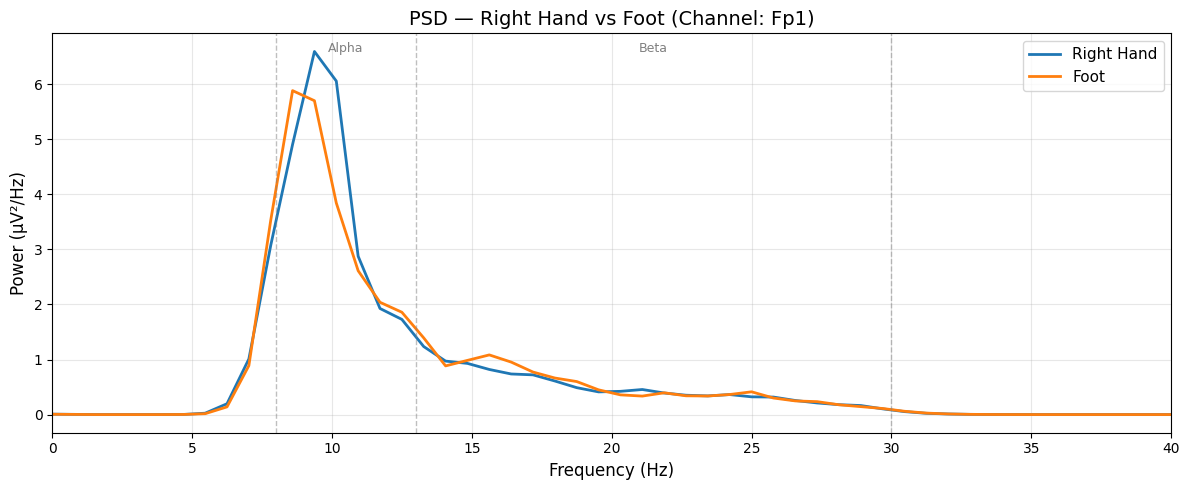

In [ ]:
print("="*60)
print("PSD ANALYSIS - RIGHT HAND VS FOOT")
print("="*60)

channel_name = 'Fp1'

try:
    channel_idx = clab.index(channel_name)
    print(f"Selected channel: {channel_name} (index: {channel_idx})")
except ValueError:
    print(f"ERROR: Channel '{channel_name}' not found!")
    print(f"Available motor channels: {[ch for ch in clab if 'C' in ch.upper()]}")
    raise

print(f"\nData shape: {X_labeled.shape}")
right_hand_epochs = X_labeled[y_labeled == 1]
foot_epochs       = X_labeled[y_labeled == 2]

print(f"Right hand epochs: {right_hand_epochs.shape}")
print(f"Foot epochs: {foot_epochs.shape}")

fs = 100

def compute_mean_psd(epochs, fs, channel):
    """Compute mean PSD across epochs for a single channel"""
    psds = []
    for ep in epochs:
        f, Pxx = welch(ep[:, channel], fs=fs, nperseg=128)
        psds.append(Pxx)
    return f, np.mean(psds, axis=0)

print(f"\nComputing PSD for channel {channel_name}...")
f, psd_right = compute_mean_psd(right_hand_epochs, fs, channel_idx)
_, psd_foot  = compute_mean_psd(foot_epochs, fs, channel_idx)


plt.figure(figsize=(12, 5))
plt.plot(f, psd_right, label="Right Hand", linewidth=2, )
plt.plot(f, psd_foot,  label="Foot", linewidth=2,)

plt.title(f"PSD — Right Hand vs Foot (Channel: {channel_name})",
          fontsize=14,)
plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("Power (µV²/Hz)", fontsize=12)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(0, 40)

plt.axvline(x=8, color='gray', linestyle='--', alpha=0.5, linewidth=1)
plt.axvline(x=13, color='gray', linestyle='--', alpha=0.5, linewidth=1)
plt.axvline(x=30, color='gray', linestyle='--', alpha=0.5, linewidth=1)

plt.text(10.5, plt.ylim()[1]*0.95, 'Alpha', ha='center', fontsize=9, color='gray')
plt.text(21.5, plt.ylim()[1]*0.95, 'Beta', ha='center', fontsize=9, color='gray')

plt.tight_layout()


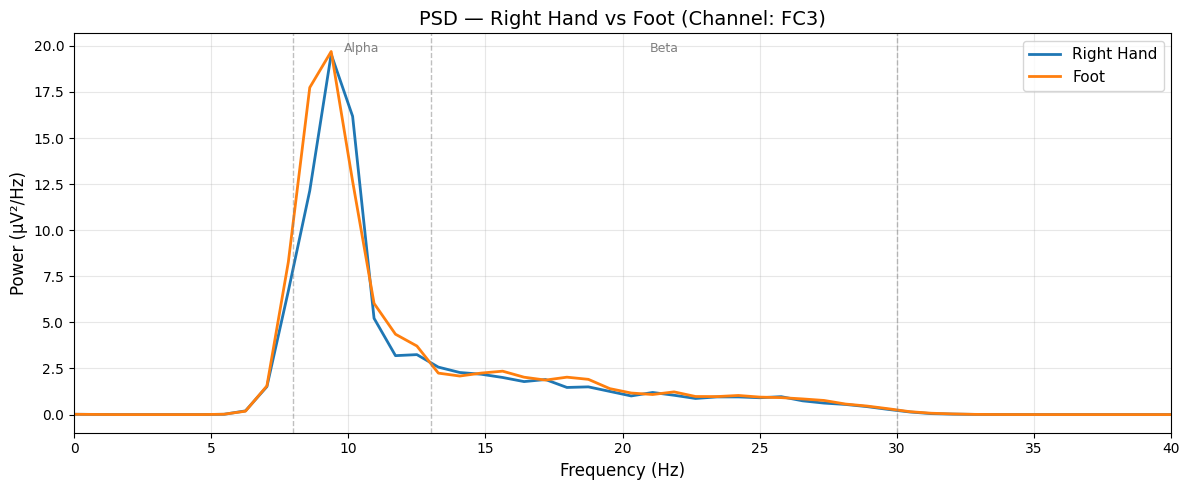

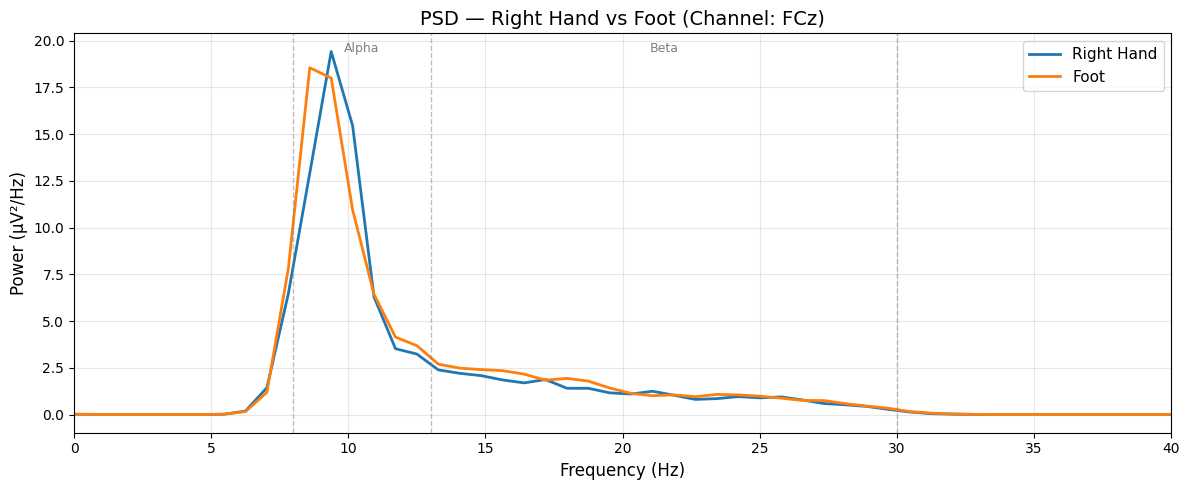

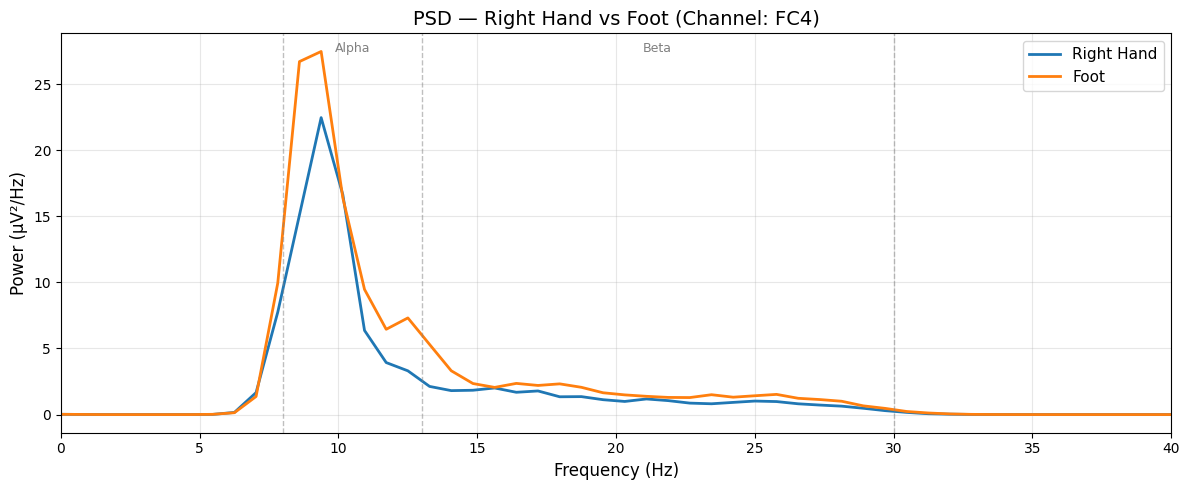

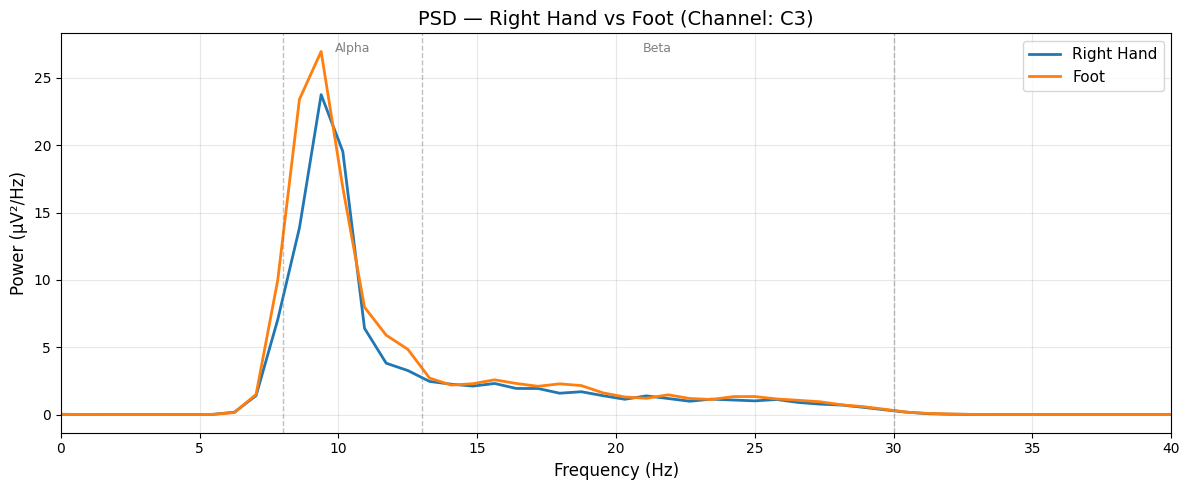

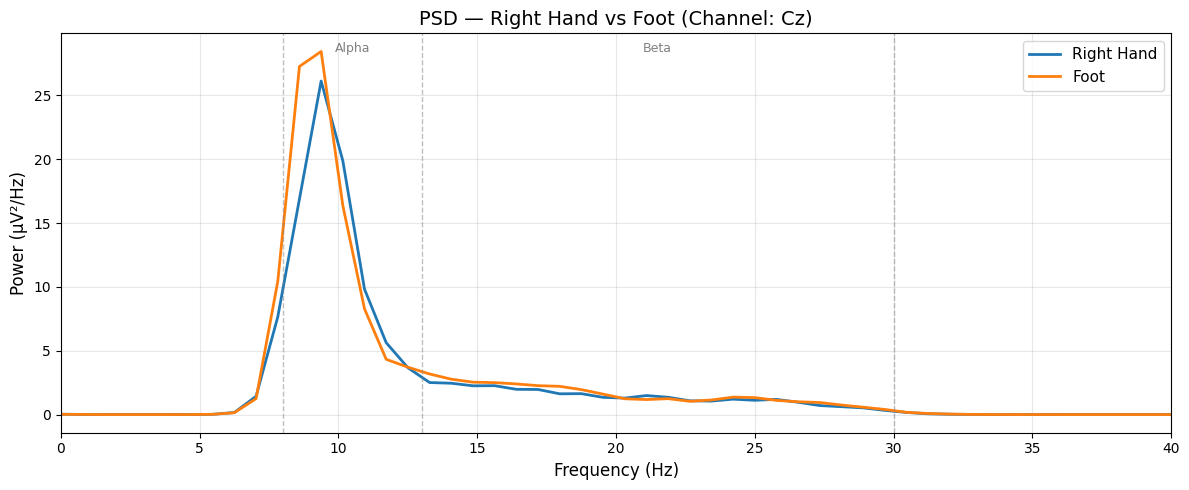

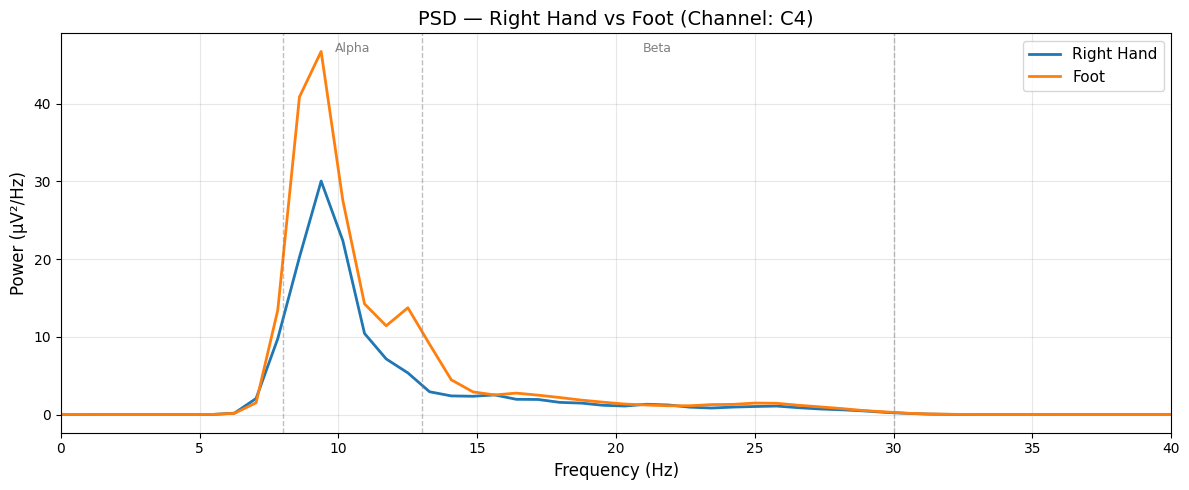

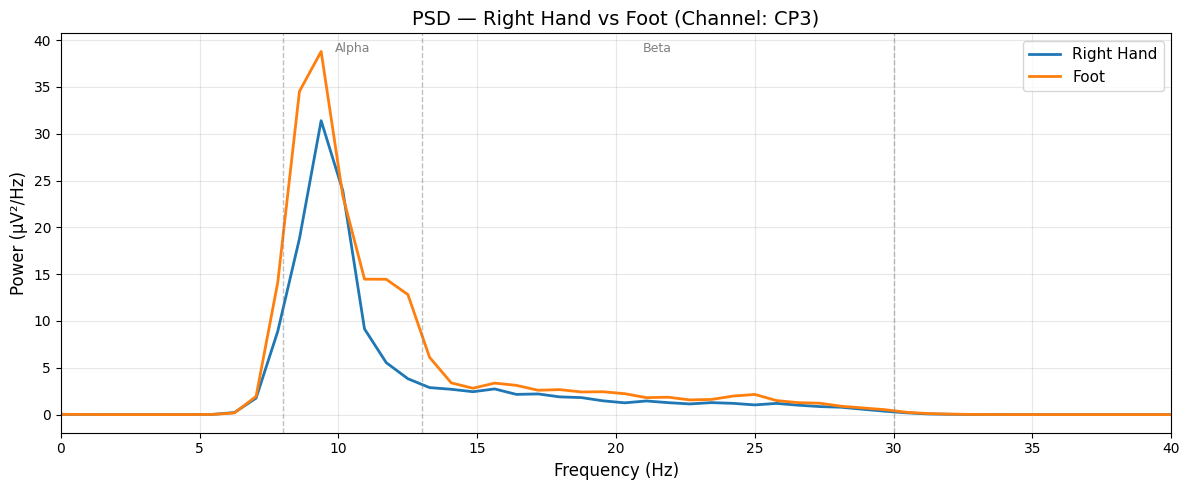

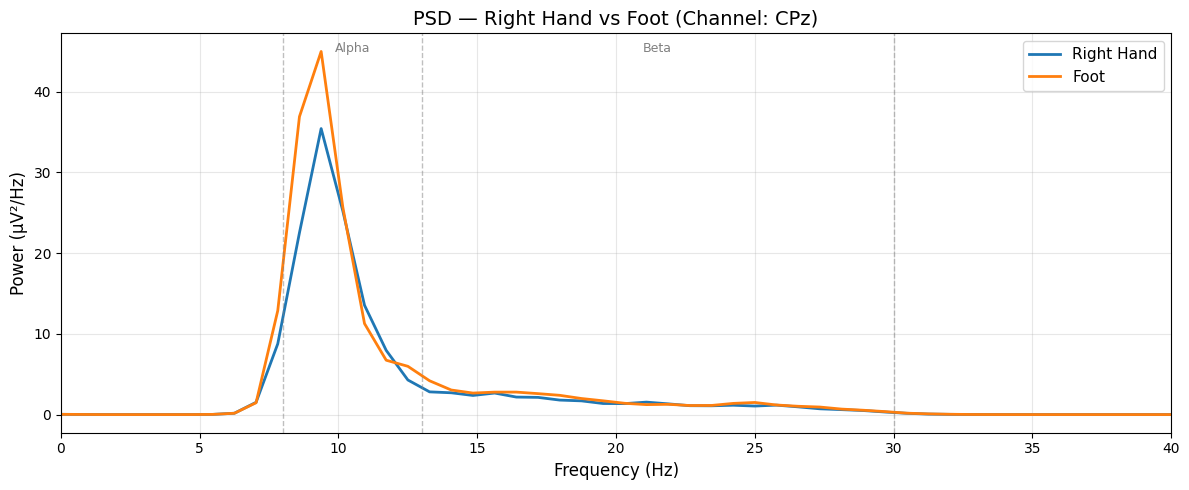

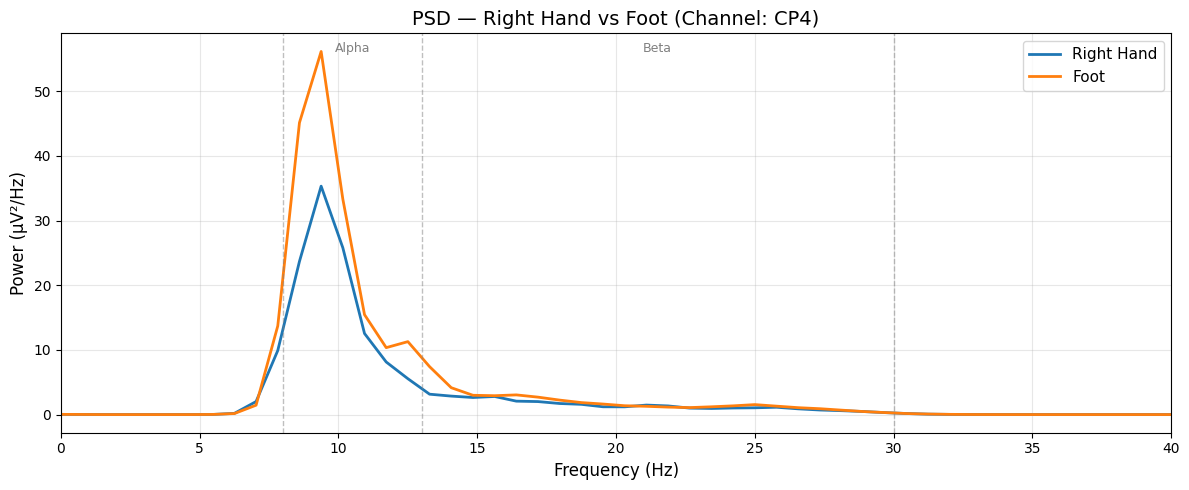

In [ ]:
target_names = ["C3", "C4", "Cz", "FC3", "FC4", "FCz", "CP3", "CP4", "CPz"]

target_names_lower = [t.lower() for t in target_names]


clab_lower = [label.lower() for label in clab]

motor_channel_indices = [
    i for i, label_lower in enumerate(clab_lower)
    if label_lower in target_names_lower
]


right_hand_epochs = X_labeled[y_labeled == 1]
foot_epochs       = X_labeled[y_labeled == 2]

fs = 100


def compute_mean_psd(epochs, fs, ch):
    """Compute mean PSD across epochs for a single channel"""
    psds = []
    for ep in epochs:
        f, Pxx = welch(ep[:, ch], fs=fs, nperseg=128)
        psds.append(Pxx)
    return f, np.mean(psds, axis=0)



for i, ch_global_index in enumerate(motor_channel_indices):
    ch_name = clab[ch_global_index]

    f, psd_right = compute_mean_psd(right_hand_epochs, fs, ch_global_index)
    _, psd_foot  = compute_mean_psd(foot_epochs, fs, ch_global_index)

    plt.figure(figsize=(12, 5))
    plt.plot(f, psd_right, label="Right Hand", linewidth=2, )
    plt.plot(f, psd_foot,  label="Foot", linewidth=2,)

    plt.title(f"PSD — Right Hand vs Foot (Channel: {ch_name})",
              fontsize=14,)
    plt.xlabel("Frequency (Hz)", fontsize=12)
    plt.ylabel("Power (µV²/Hz)", fontsize=12)
    plt.legend(fontsize=11, loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 40)

    plt.axvline(x=8, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(x=13, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(x=30, color='gray', linestyle='--', alpha=0.5, linewidth=1)

    plt.text(10.5, plt.ylim()[1]*0.95, 'Alpha', ha='center', fontsize=9, color='gray')
    plt.text(21.5, plt.ylim()[1]*0.95, 'Beta', ha='center', fontsize=9, color='gray')

    plt.tight_layout()
    plt.show()

# Model Training and Evaluation

In [ ]:
true_lables=loadmat('/content/true_labels_aw.mat')


In [ ]:
actual=true_lables['true_y'].flatten()

In [ ]:
y_test=actual[56:]

In [ ]:
def zscore_per_trial(X):
    mean = X.mean(axis=1, keepdims=True)
    std  = X.std(axis=1, keepdims=True)
    return (X - mean) / std

def reorder_for_csp(X):
    return np.transpose(X, (0, 2, 1))


def training_pipeline(X_train, y_train, X_test, y_test,
                            max_components=12, n_cv_folds=5):

    print("="*60)
    print("CSP+LDA TRAINING WITH 5-FOLD CV")
    print("="*60)

    X_train_csp = reorder_for_csp(zscore_per_trial(X_train))
    X_test_csp = reorder_for_csp(zscore_per_trial(X_test))

    best_score = 0
    best_n = 0
    results = []

    print(f"\nTesting {max_components} different CSP component counts:")
    print("Components | CV Mean ± Std  | Best")
    print("-" * 45)

    for n_comp in range(1, max_components + 1):
        pipeline = Pipeline([
            ('csp', CSP(n_components=n_comp, reg=None, log=True, norm_trace=False)),
            ('lda', LDA())
        ])

        cv = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=42)
        cv_scores = cross_val_score(pipeline, X_train_csp, y_train,
                                    cv=cv, scoring='accuracy', n_jobs=-1)

        mean_score = cv_scores.mean()
        std_score = cv_scores.std()

        results.append({
            'n_components': n_comp,
            'cv_mean': mean_score,
            'cv_std': std_score,
            'cv_scores': cv_scores
        })

        is_best = ""
        if mean_score > best_score:
            best_score = mean_score
            best_n = n_comp
            is_best = " ← BEST"

        print(f"    {n_comp:2d}     | {mean_score:.4f} ± {std_score:.4f} {is_best}")

    print(f"\n{'='*60}")
    print(f"Training final model with {best_n} components")
    print(f"CV Score: {best_score:.4f}")
    print(f"{'='*60}")


    final_pipeline = Pipeline([
        ('csp', CSP(n_components=best_n, reg=None, log=True, norm_trace=False)),
        ('lda', LDA())
    ])

    final_pipeline.fit(X_train_csp, y_train)


    csp_transformer = final_pipeline.named_steps['csp']
    csp_features_train = csp_transformer.transform(X_train_csp)

    train_acc = final_pipeline.score(X_train_csp, y_train)
    test_acc = final_pipeline.score(X_test_csp, y_test)

    print(f"\nFinal Results:")
    print(f"  Training accuracy: {train_acc:.4f}")
    print(f"  Test accuracy: {test_acc:.4f}")
    print(f"  CV accuracy: {best_score:.4f}")
    print(f"  Generalization: {test_acc - train_acc:+.4f}")


    return final_pipeline, results, best_n, csp_features_train, X_test_csp

model, results, best_components, csp_features, X_test = training_pipeline(
    X_labeled, y_labeled,
    X_unlabeled, y_test,
    max_components=12,
    n_cv_folds=5
)


CSP+LDA TRAINING WITH 5-FOLD CV

Testing 12 different CSP component counts:
Components | CV Mean ± Std  | Best
---------------------------------------------
     1     | 0.9273 ± 0.1060  ← BEST
     2     | 0.9455 ± 0.0727  ← BEST
     3     | 0.9273 ± 0.0891 
     4     | 0.8561 ± 0.0739 
     5     | 0.8561 ± 0.0739 
     6     | 0.8924 ± 0.0894 
     7     | 0.8924 ± 0.0894 
     8     | 0.8379 ± 0.1345 
     9     | 0.8561 ± 0.1483 
    10     | 0.8379 ± 0.1345 
    11     | 0.8561 ± 0.1099 
    12     | 0.8561 ± 0.1099 

Training final model with 2 components
CV Score: 0.9455

Final Results:
  Training accuracy: 0.9821
  Test accuracy: 0.8973
  CV accuracy: 0.9455
  Generalization: -0.0848


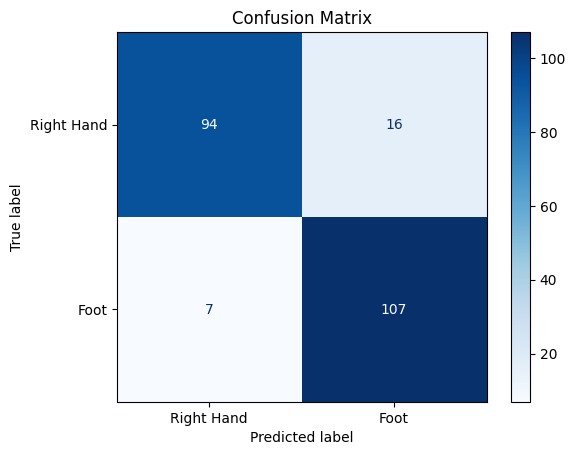

In [ ]:
y_pred=model.predict(X_test)
cm_test = confusion_matrix(y_test,y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=["Right Hand", "Foot"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=["Right Hand", "Foot"]))


              precision    recall  f1-score   support

  Right Hand       0.93      0.85      0.89       110
        Foot       0.87      0.94      0.90       114

    accuracy                           0.90       224
   macro avg       0.90      0.90      0.90       224
weighted avg       0.90      0.90      0.90       224



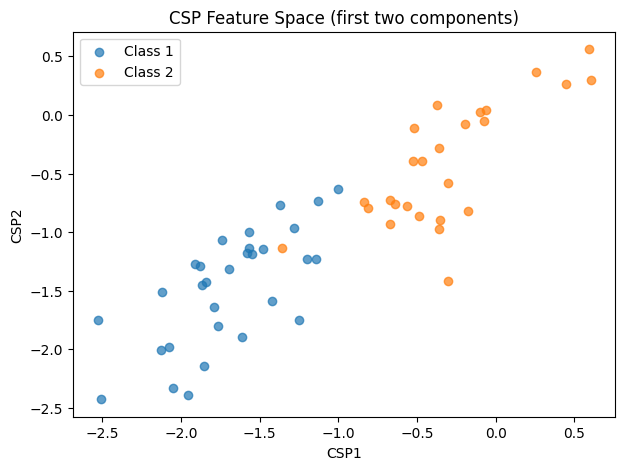

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(csp_features[y_labeled==1,0], csp_features[y_labeled==1,1], label="Class 1", alpha=0.7)
plt.scatter(csp_features[y_labeled==2,0], csp_features[y_labeled==2,1], label="Class 2", alpha=0.7)
plt.title("CSP Feature Space (first two components)")
plt.xlabel("CSP1")
plt.ylabel("CSP2")
plt.legend()
plt.show()


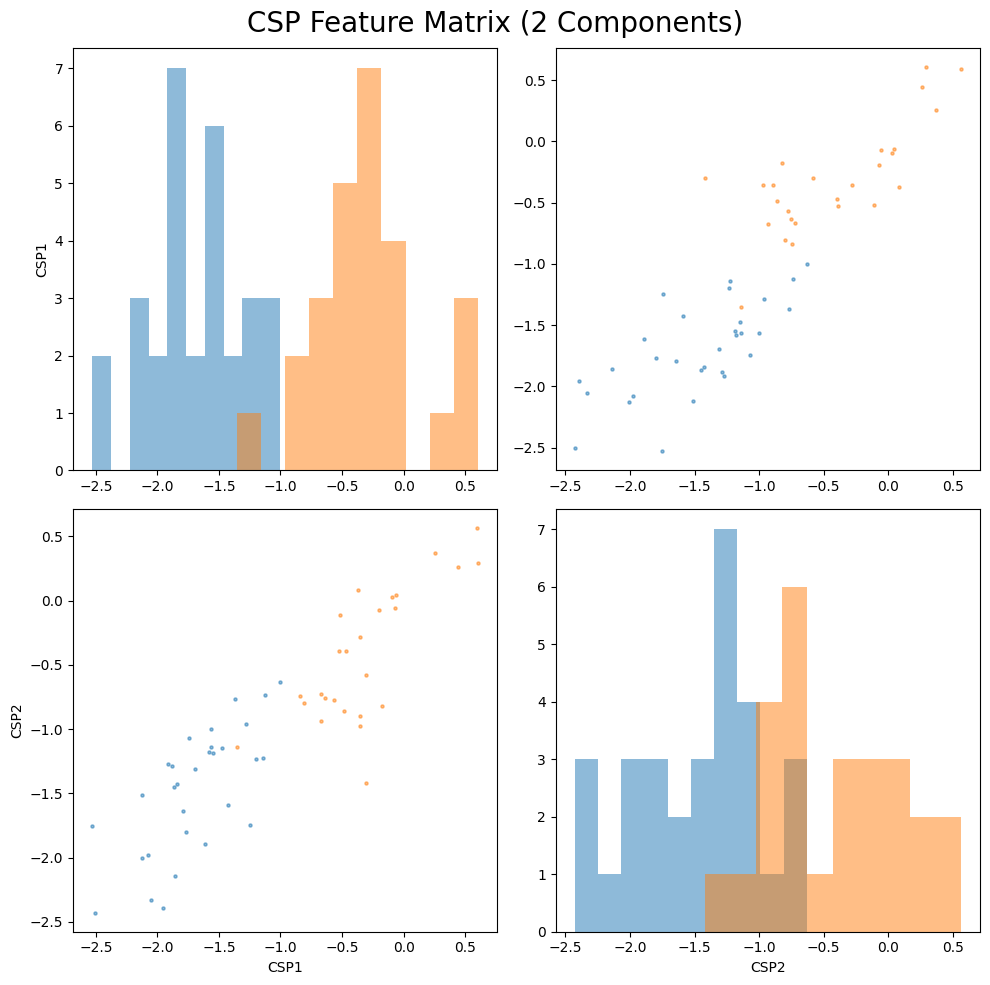

In [ ]:
components = 2
fig, axes = plt.subplots(components, components, figsize=(10,10))

for i in range(components):
    for j in range(components):
        ax = axes[i,j]
        if i == j:
            ax.hist(csp_features[y_labeled==1, i], alpha=0.5, label='Class 1')
            ax.hist(csp_features[y_labeled==2, i], alpha=0.5, label='Class 2')
        else:
            ax.scatter(csp_features[y_labeled==1, j],
                       csp_features[y_labeled==1, i],
                       s=5, alpha=0.5)
            ax.scatter(csp_features[y_labeled==2, j],
                       csp_features[y_labeled==2, i],
                       s=5, alpha=0.5)
        if i == components - 1:
            ax.set_xlabel(f"CSP{j+1}")
        if j == 0:
            ax.set_ylabel(f"CSP{i+1}")

plt.suptitle("CSP Feature Matrix (2 Components)", fontsize=20)
plt.tight_layout()
plt.show()


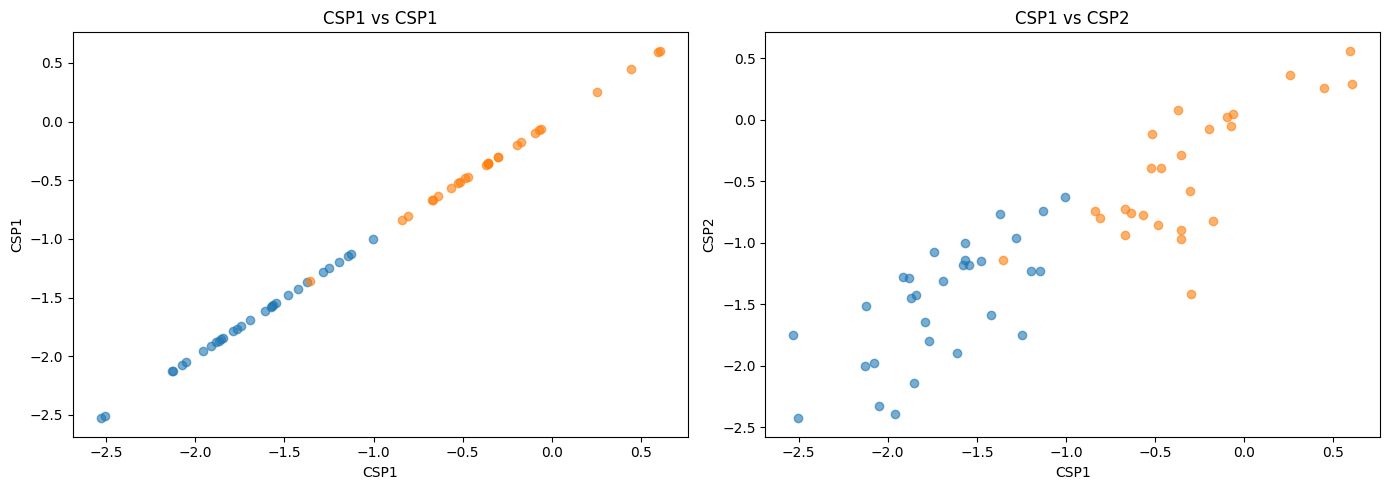

In [ ]:
plt.figure(figsize=(14,5))

for i in range(2):
    plt.subplot(1,2,i+1)
    plt.scatter(csp_features[y_labeled==1,0],
                csp_features[y_labeled==1,i],
                alpha=0.6, label="Class 1")
    plt.scatter(csp_features[y_labeled==2,0],
                csp_features[y_labeled==2,i],
                alpha=0.6, label="Class 2")
    plt.xlabel("CSP1")
    plt.ylabel(f"CSP{i+1}")
    plt.title(f"CSP1 vs CSP{i+1}")

plt.tight_layout()
plt.show()


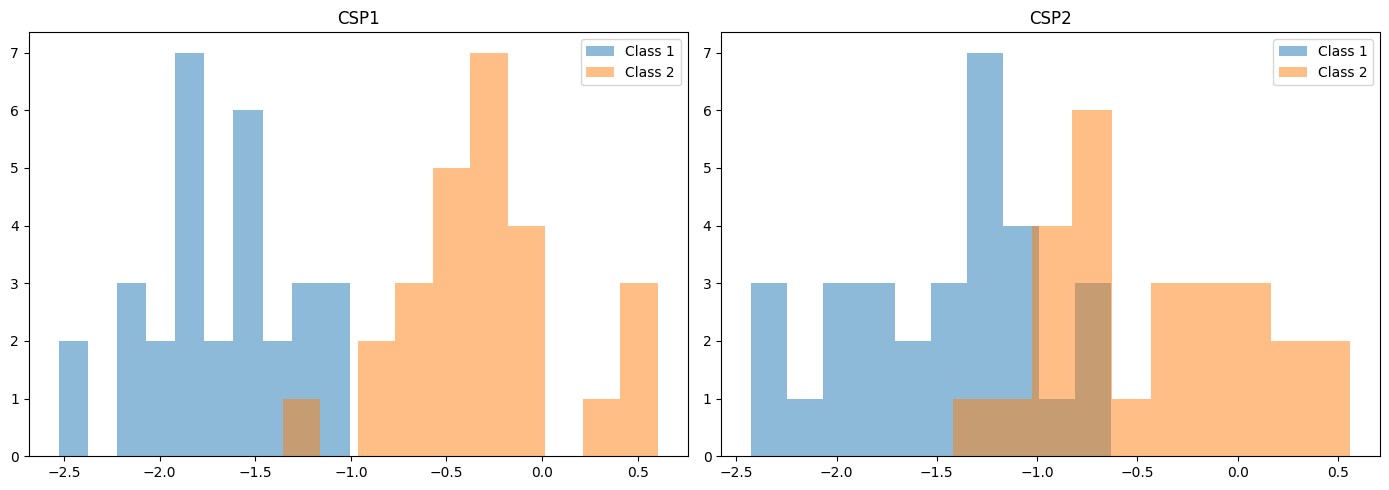

In [ ]:
plt.figure(figsize=(14,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.hist(csp_features[y_labeled==1, i], alpha=0.5, label='Class 1')
    plt.hist(csp_features[y_labeled==2, i], alpha=0.5, label='Class 2')
    plt.title(f"CSP{i+1}")
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
model_filename = 'subject_aw_model'
joblib.dump(model, model_filename)

